In [56]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [135]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from scipy.stats import mannwhitneyu
warnings.filterwarnings("ignore")
from data_utils import convert_duration, get_category_mapping, LanguageDetector

In [58]:
# load data
df_page = pd.read_csv('query_results/pageInfo.csv')
df_info = pd.read_parquet('query_results/video_info.parquet')
df_details = pd.read_parquet('query_results/video_details.parquet')
df_comments = pd.read_parquet('query_results/comment_info.parquet')

In [59]:
FITSPO_Q = "fitspo|fitspiration"
BODY_POSI_Q = "bodypositive|bodypositivity"

# Define a dictionary to map keywords to colors
keyword_color_mapping = {FITSPO_Q: sns.color_palette("pastel")[0], BODY_POSI_Q: sns.color_palette("pastel")[1]}
# grayscale_palette = sns.color_palette("Greys_r", n_colors=len(df_page['keyword'].unique()))

## EDA on search results
The dataset contains query results using YouTube API's ```search``` method. 

In [5]:
# each row is a query made to search for videos using the keyword
df_page.head()

,keyword,published_after,published_before,total_results,returned_results
0,fitspo|fitspiration,2013-01-01T00:00:00Z,2013-06-30T23:59:59Z,2322,46
1,bodypositive|bodypositivity,2013-01-01T00:00:00Z,2013-06-30T23:59:59Z,9172,0
2,fitspo|fitspiration,2013-07-01T00:00:00Z,2013-12-31T23:59:59Z,1995,50
3,bodypositive|bodypositivity,2013-07-01T00:00:00Z,2013-12-31T23:59:59Z,8593,1
4,fitspo|fitspiration,2014-01-01T00:00:00Z,2014-06-30T23:59:59Z,4183,46


### Questions to answer: how many results (vidoes) are returned for each keyword? 
Note that for each keyword, 22 API calls were made, with max results per call being 50. The maximum number of results per keyword possible is 22*50=1100.

According to YouTube API [https://developers.google.com/youtube/v3/docs/search/list#pageInfo.totalResults]:
- ```total_results```: The total number of results in the result set.Please note that the value is an approximation and may not represent an exact value. In addition, the maximum value is 1,000,000.
- ```returned_results```: The number of results included in the API response.

In [6]:
fitspo_total = df_page[df_page['keyword'] == FITSPO_Q]['total_results'].sum()
bodyposi_total = df_page[df_page['keyword'] == BODY_POSI_Q]['total_results'].sum()
fitspo_returned = df_page[df_page['keyword'] == FITSPO_Q]['returned_results'].sum()
bodyposi_returned = df_page[df_page['keyword'] == BODY_POSI_Q]['returned_results'].sum()

In [8]:
# construct a dataframe 
df = pd.DataFrame({'keyword': [FITSPO_Q, BODY_POSI_Q], 
                   'total_results': [fitspo_total, bodyposi_total],
                   'returned_results': [fitspo_returned, bodyposi_returned],
                   'results_requested': [1100, 1100],
                   'returned_requested_ratio': [fitspo_returned/1100, bodyposi_returned/1100]})
os.makedirs('results', exist_ok=True)
df.to_csv('results/keyword_search.csv', index=False)
df

,keyword,total_results,returned_results,results_requested,returned_requested_ratio
0,fitspo|fitspiration,564977,1045,1100,0.950000
1,bodypositive|bodypositivity,7382354,752,1100,0.683636


### Questions to answer: how many videos are returned for each keyword published in different years?

In [9]:
# extract the year from the published_after column
df_page['published_after'] = df_page['published_after'].apply(lambda x: x.split('-')[0])
# combine the rows with the same keyword and published_after
df_page = df_page.groupby(['keyword', 'published_after']).sum().reset_index()

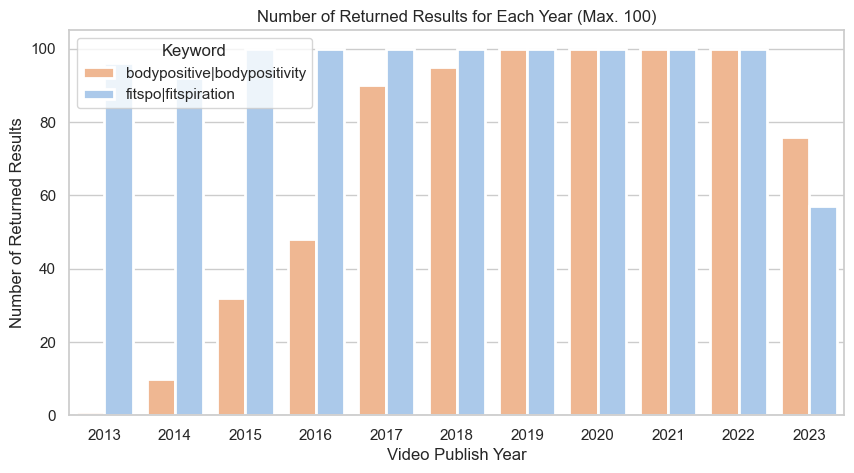

In [26]:
# bar plot of the number of videos returned for each keyword
keyword_colors = [keyword_color_mapping[keyword] for keyword in df_page['keyword'].unique()]
sns.set(style="whitegrid")
fig, ax = plt.subplots(figsize=(10, 5))
sns.barplot(x='published_after', y='returned_results', hue='keyword', data=df_page, ax=ax, palette=keyword_colors, linewidth=2)
# set x-axis labels to be the start of the period
ax.set_xticklabels(df_page['published_after'])
ax.legend(title='Keyword', loc='upper left')
ax.set_title('Number of Returned Results for Each Year (Max. 100)')
ax.set_xlabel('Video Publish Year')
ax.set_ylabel('Number of Returned Results')
plt.savefig('results/returned_results.png')

## Merge video-related DataFrames
The two DataFrames are queried with YouTube API's ```search``` and ```videos``` method respectively.

In [133]:
df_info.columns

Index(['video_id', 'title', 'description', 'published_at', 'channel_id',
       'channel_title', 'thumbnail_url', 'keyword', 'published_after',
       'published_before'],
      dtype='object')

In [134]:
df_details.columns

Index(['description', 'tags', 'category_id', 'title', 'channel_title',
       'view_count', 'like_count', 'comment_count', 'duration', 'definition',
       'video_id'],
      dtype='object')

In [61]:
# merge data acording to video_id
# keep columns from df_details because it has more complete data such as description
df_video = pd.merge(df_info, df_details, on=['video_id'], how='inner')
df_video.shape

(1797, 20)

In [62]:
# find columns with name with suffix _x and drop them
df_video.drop(df_video.filter(like='_x').columns, axis=1, inplace=True)

In [63]:
df_video.rename(columns={
    'description_y': 'description',
    'title_y': 'title',
    'channel_title_y': 'channel_title'
}, inplace=True)

In [64]:
df_video.head()

,video_id,published_at,channel_id,thumbnail_url,keyword,published_after,published_before,description,tags,category_id,title,channel_title,view_count,like_count,comment_count,duration,definition
0,nhRzkGpdQdk,2013-03-12T17:09:50Z,UC3uDucFPe-E0I6CfxtHWZ6w,https://i.ytimg.com/vi/nhRzkGpdQdk/hqdefault.jpg,fitspo|fitspiration,2013-01-01T00:00:00Z,2013-06-30T23:59:59Z,Follow me on Facebook:\nhttp://www.facebook.co...,"[Bodybuilding Motivation, ShaQx, Female Fitnes...",17,Female Fitness Motivation - Success is a Journey,ShaQx,9762915,41921,1920,PT3M12S,hd
1,sIu61gS8Qag,2013-02-15T22:11:00Z,UC87WGiHFdgzRf6XRpbIcg4Q,https://i.ytimg.com/vi/sIu61gS8Qag/hqdefault.jpg,fitspo|fitspiration,2013-01-01T00:00:00Z,2013-06-30T23:59:59Z,This is a video I made for me to stay motivate...,"[fit, fitblr, fitspiration video, abs, motivat...",22,Fitspiration Video,Samora Lewis,211373,935,50,PT4M10S,hd
2,Y4UyIC36VqQ,2013-02-11T03:44:28Z,UC9aRTMF4m6aBzkyhchwsWHQ,https://i.ytimg.com/vi/Y4UyIC36VqQ/hqdefault.jpg,fitspo|fitspiration,2013-01-01T00:00:00Z,2013-06-30T23:59:59Z,Find us at http://alluring-beauties.tumblr.com...,"[girls, weightloss, fitspo, thinsp, skinny, sl...",22,"Real Girl Weight loss, Before and After. Fitspo",AlluringBeautiesPage,108440,263,35,PT1M53S,hd
3,HQtyF3YmYpw,2013-05-07T03:33:06Z,UCLIeO7AnzCpod8GiZsxyx5w,https://i.ytimg.com/vi/HQtyF3YmYpw/hqdefault.jpg,fitspo|fitspiration,2013-01-01T00:00:00Z,2013-06-30T23:59:59Z,just some weight lose/toning inspiration for y...,"[thinspo, curves, curvy, sexy, curvespo, lose ...",26,Fitspo for girls with curves 2013 (curvespo),LovesIt50,63819,83,3,PT4M13S,sd
4,XXrvhTVlm0s,2013-03-16T18:17:29Z,UCgsNAoSMqikDqYOUXyasaLg,https://i.ytimg.com/vi/XXrvhTVlm0s/hqdefault.jpg,fitspo|fitspiration,2013-01-01T00:00:00Z,2013-06-30T23:59:59Z,hope you like this Fitspo Video :D \nwant to l...,"[fitspiration, fitspo, fitness, thin, thinspir...",22,FITSPIRATION - Fitnessmodel,fitandthin,30885,130,6,PT2M9S,sd


In [65]:
os.makedirs('preprocessed_data', exist_ok=True)
df_video.to_parquet('preprocessed_data/video_info_details_raw.parquet')

## EDA on video-related data

In [66]:
print(f"{df_video.shape[0]} videos were collected.")

1797 videos were collected.


### avg. view count, like count, comment count for each keyword published in different years

In [67]:
# avg. view count, like count, comment count for each keyword published in different years
df_video['publish_year'] = df_video['published_at'].apply(lambda x: x.split('-')[0])

# Convert relevant columns to numeric
df_video['view_count'] = pd.to_numeric(df_video['view_count'], errors='coerce')
df_video['like_count'] = pd.to_numeric(df_video['like_count'], errors='coerce')
df_video['comment_count'] = pd.to_numeric(df_video['comment_count'], errors='coerce')

# Calculate average values
df_avg = df_video.groupby(['keyword','publish_year'])[['view_count', 'like_count', 'comment_count']].mean().reset_index()

In [136]:
df_avg.head()

,keyword,publish_year,view_count,like_count,comment_count
0,bodypositive|bodypositivity,2013,46.000000,0.000000,0.000000
1,bodypositive|bodypositivity,2014,5436.600000,170.000000,50.600000
2,bodypositive|bodypositivity,2015,22898.625000,949.875000,68.482759
3,bodypositive|bodypositivity,2016,20958.000000,542.395833,99.687500
4,bodypositive|bodypositivity,2017,9850.233333,184.325843,45.265823


In [137]:
# significance test for the average view count, like count, comment count for each keyword published across years
statistic, p_value = mannwhitneyu(df_avg[df_avg['keyword'] == FITSPO_Q]['view_count'], df_avg[df_avg['keyword'] == BODY_POSI_Q]['view_count'])
print(f"View Count: p-value = {p_value:.4f}")

statistic, p_value = mannwhitneyu(df_avg[df_avg['keyword'] == FITSPO_Q]['like_count'], df_avg[df_avg['keyword'] == BODY_POSI_Q]['like_count'])
print(f"Like Count: p-value = {p_value:.4f}")

statistic, p_value = mannwhitneyu(df_avg[df_avg['keyword'] == FITSPO_Q]['comment_count'], df_avg[df_avg['keyword'] == BODY_POSI_Q]['comment_count'])
print(f"Comment Count: p-value = {p_value:.4f}")

View Count: p-value = 0.5545
Like Count: p-value = 0.8438
Comment Count: p-value = 0.1679


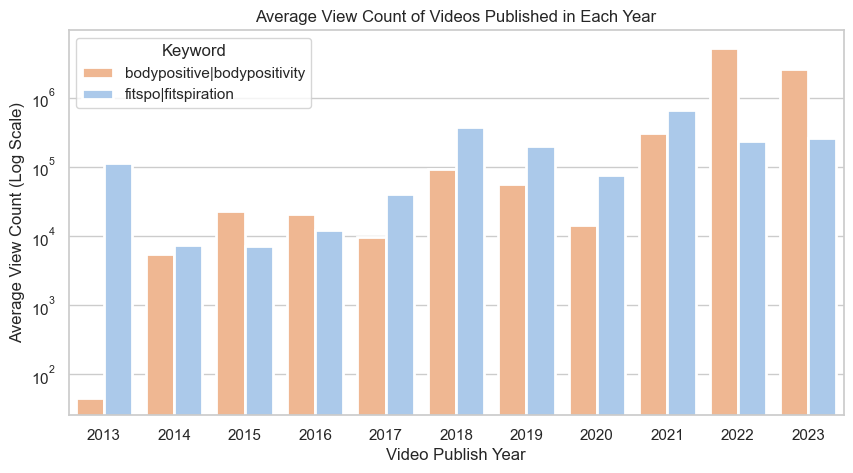

In [27]:
# bar plot of the number of videos returned for each keyword
keyword_colors = [keyword_color_mapping[keyword] for keyword in df_avg['keyword'].unique()]
sns.set(style="whitegrid")
fig, ax = plt.subplots(figsize=(10, 5))
sns.barplot(x='publish_year', y='view_count', hue='keyword', data=df_avg, ax=ax, palette=keyword_colors, linewidth=2)
# Set log scale for y-axis
ax.set_yscale('log')
ax.legend(title='Keyword', loc='upper left')
ax.set_xticklabels(df_avg['publish_year'])
ax.set_title('Average View Count of Videos Published in Each Year')
ax.set_xlabel('Video Publish Year')
ax.set_ylabel('Average View Count (Log Scale)')
plt.savefig('results/avg_view_count.png')

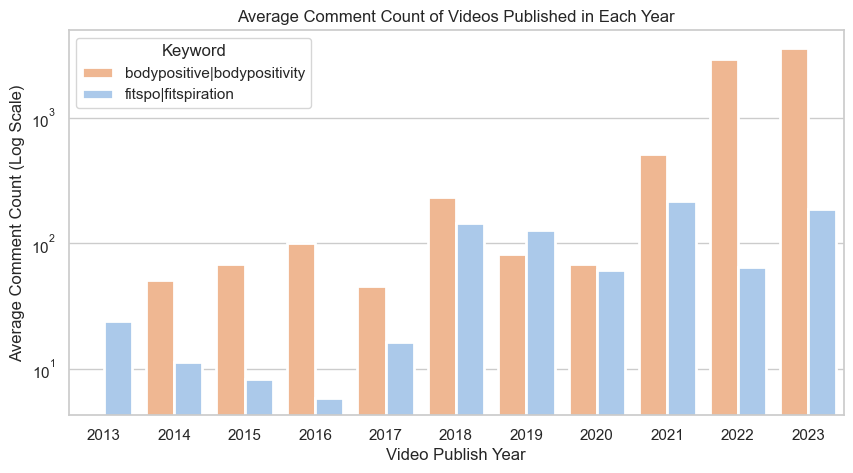

In [28]:
# bar plot of the number of videos returned for each keyword
keyword_colors = [keyword_color_mapping[keyword] for keyword in df_avg['keyword'].unique()]
sns.set(style="whitegrid")
fig, ax = plt.subplots(figsize=(10, 5))
sns.barplot(x='publish_year', y='comment_count', hue='keyword', data=df_avg, ax=ax, palette=keyword_colors, linewidth=2)
# Set log scale for y-axis
ax.set_yscale('log')
ax.legend(title='Keyword', loc='upper left')
ax.set_xticklabels(df_avg['publish_year'])
ax.set_title('Average Comment Count of Videos Published in Each Year')
ax.set_xlabel('Video Publish Year')
ax.set_ylabel('Average Comment Count (Log Scale)')
plt.savefig('results/avg_comment_count.png')

In [156]:
# significance test for the view count for each keyword published across years
for year in df_video['publish_year'].unique():
    fitspo_view_count = df_video[(df_video['keyword'] == FITSPO_Q) & (df_video['publish_year'] == str(year))]['view_count'].dropna()
    bopo_view_count = df_video[(df_video['keyword'] == BODY_POSI_Q) & (df_video['publish_year'] == str(year))]['view_count'].dropna()

    if len(fitspo_view_count) > 0 and len(bopo_view_count) > 0:
        statistic, p_value = mannwhitneyu(fitspo_view_count.values, bopo_view_count.values)
        print(f"For Year {year}: p-value = {p_value:.4f}")
    else:
        print(f"For Year {year}: Insufficient data for comparison")


For Year 2013: p-value = 0.4704
For Year 2014: p-value = 0.2800
For Year 2015: p-value = 0.0055
For Year 2016: p-value = 0.0013
For Year 2017: p-value = 0.3912
For Year 2018: p-value = 0.0000
For Year 2019: p-value = 0.0000
For Year 2020: p-value = 0.0034
For Year 2021: p-value = 0.7666
For Year 2022: p-value = 0.0000
For Year 2023: p-value = 0.0000


In [155]:
# significance test for the comment count for each keyword published across years
for year in df_video['publish_year'].unique():
    fitspo_comment_count = df_video[(df_video['keyword'] == FITSPO_Q) & (df_video['publish_year'] == str(year))]['comment_count'].dropna()
    bopo_comment_count = df_video[(df_video['keyword'] == BODY_POSI_Q) & (df_video['publish_year'] == str(year))]['comment_count'].dropna()

    if len(fitspo_comment_count) > 0 and len(bopo_comment_count) > 0:
        statistic, p_value = mannwhitneyu(fitspo_comment_count.values, bopo_comment_count.values)
        print(f"For Year {year}: p-value = {p_value:.4f}")
    else:
        print(f"For Year {year}: Insufficient data for comparison")


For Year 2013: p-value = 0.4399
For Year 2014: p-value = 0.6313
For Year 2015: p-value = 0.0152
For Year 2016: p-value = 0.1690
For Year 2017: p-value = 0.1206
For Year 2018: p-value = 0.2538
For Year 2019: p-value = 0.0947
For Year 2020: p-value = 0.4971
For Year 2021: p-value = 0.4811
For Year 2022: p-value = 0.0000
For Year 2023: p-value = 0.0000


### View count, like count, comment count distribution among videos

In [195]:
year = 2022

# filter the data for the year
df_video_year = df_video[df_video['publish_year'] == str(year)]
df_video_year.shape

(200, 18)

Choose the year 2022 for example because it has full returned results (50 per half year) for both keywords.

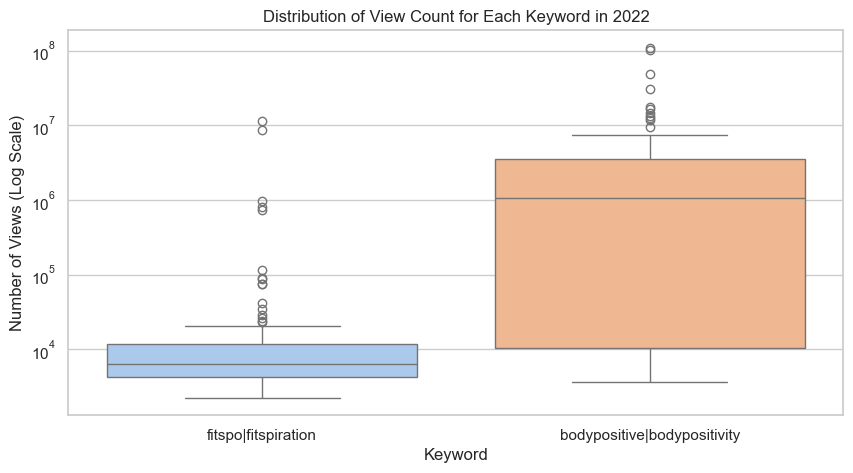

In [179]:
keyword_colors = [keyword_color_mapping[keyword] for keyword in df_video_year['keyword'].unique()]
sns.set(style="whitegrid")
fig, ax = plt.subplots(figsize=(10, 5))
sns.boxplot(data=df_video_year, x='keyword', y='view_count', ax=ax, palette=keyword_colors)
ax.set_yscale('log')
ax.set_title(f'Distribution of View Count for Each Keyword in {year}')
ax.set_xlabel('Keyword')
ax.set_ylabel('Number of Views (Log Scale)')

plt.savefig(f'results/boxplot_view_count_{year}.png')
plt.show();

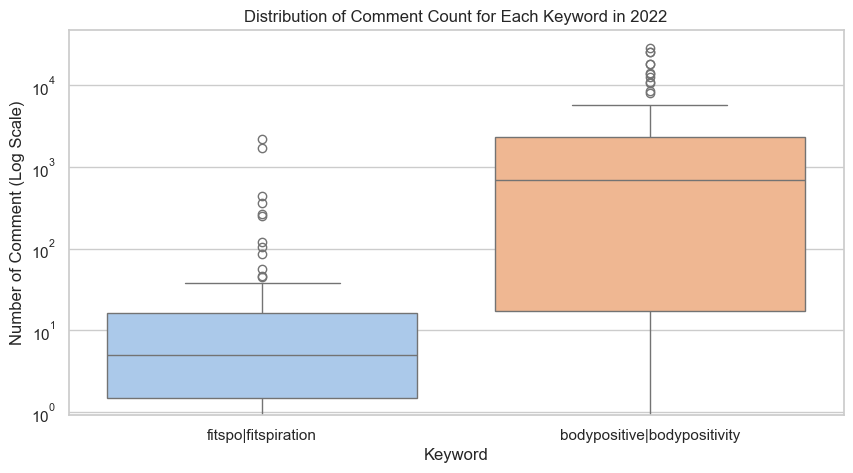

In [180]:
keyword_colors = [keyword_color_mapping[keyword] for keyword in df_video_year['keyword'].unique()]
sns.set(style="whitegrid")
fig, ax = plt.subplots(figsize=(10, 5))
sns.boxplot(data=df_video_year, x='keyword', y='comment_count', ax=ax, palette=keyword_colors)
ax.set_yscale('log')
ax.set_title(f'Distribution of Comment Count for Each Keyword in {year}')
ax.set_xlabel('Keyword')
ax.set_ylabel('Number of Comment (Log Scale)')

plt.savefig(f'results/boxplot_comment_count_{year}.png')
plt.show();

### Duration distribution for each keyword

In [69]:
df_video['duration'] = df_video['duration'].apply(convert_duration)
df_video['duration'].dtypes

dtype('int64')

In [70]:
df_video.to_parquet('preprocessed_data/video_info_details_raw.parquet') # save the data

In [71]:
df_duration = df_video.groupby(['keyword','publish_year'])[['duration']].mean().reset_index()
df_duration

,keyword,publish_year,duration
0,bodypositive|bodypositivity,2013,130.000000
1,bodypositive|bodypositivity,2014,289.900000
2,bodypositive|bodypositivity,2015,459.937500
3,bodypositive|bodypositivity,2016,491.895833
4,bodypositive|bodypositivity,2017,345.844444
5,bodypositive|bodypositivity,2018,643.873684
6,bodypositive|bodypositivity,2019,479.930000
7,bodypositive|bodypositivity,2020,770.730000
8,bodypositive|bodypositivity,2021,223.920000
9,bodypositive|bodypositivity,2022,34.510000


In [72]:
df_video.groupby(['keyword'])[['view_count', 'like_count', 'comment_count', 'duration']].mean().to_csv('results/avg_per_keyword.csv')
df_video.groupby(['keyword'])[['view_count', 'like_count', 'comment_count', 'duration']].mean()

,view_count,like_count,comment_count,duration
keyword,,,,
bodypositive|bodypositivity,1.033954e+06,35396.28592,907.376552,389.034574
fitspo|fitspiration,1.805819e+05,3278.70098,77.813765,303.109091


In [73]:
df_duration.groupby(['publish_year'])[['duration']].mean().to_csv('results/avg_duration_per_year.csv')
df_duration.groupby(['publish_year'])[['duration']].mean()

,duration
publish_year,
2013,185.802083
2014,245.917391
2015,396.643750
2016,309.527917
2017,272.647222
2018,500.481842
2019,454.955000
2020,587.240000
2021,415.765000


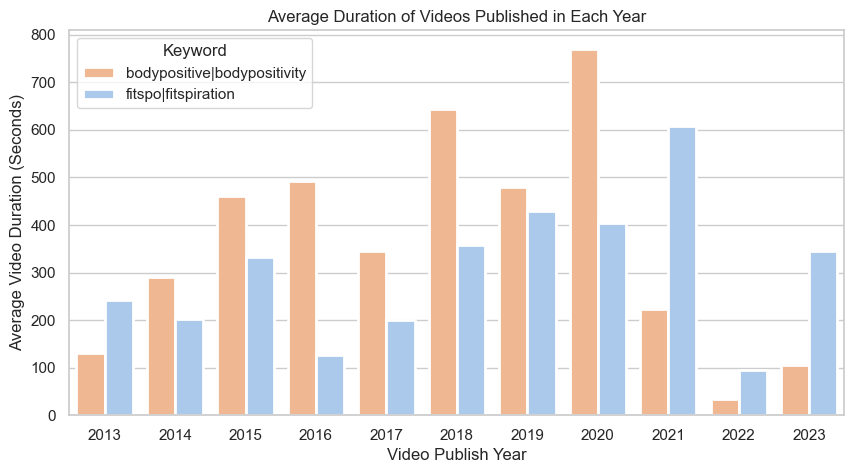

In [80]:
# bar plot of the duration of videos of each keyword per year
keyword_colors = [keyword_color_mapping[keyword] for keyword in df_duration['keyword'].unique()]
sns.set(style="whitegrid")
fig, ax = plt.subplots(figsize=(10, 5))
sns.barplot(x='publish_year', y='duration', hue='keyword', data=df_duration, ax=ax, palette=keyword_colors, linewidth=2)
ax.set_xticklabels(df_duration['publish_year'])
ax.legend(title='Keyword', loc='upper left')
ax.set_title('Average Duration of Videos Published in Each Year')
ax.set_xlabel('Video Publish Year')
ax.set_ylabel('Average Video Duration (Seconds)')
plt.savefig('results/avg_duration_per_year.png')

In [76]:
year = 2020

# filter the data for the year
df_video_year = df_video[df_video['publish_year'] == str(year)]
df_video_year.shape

(200, 18)

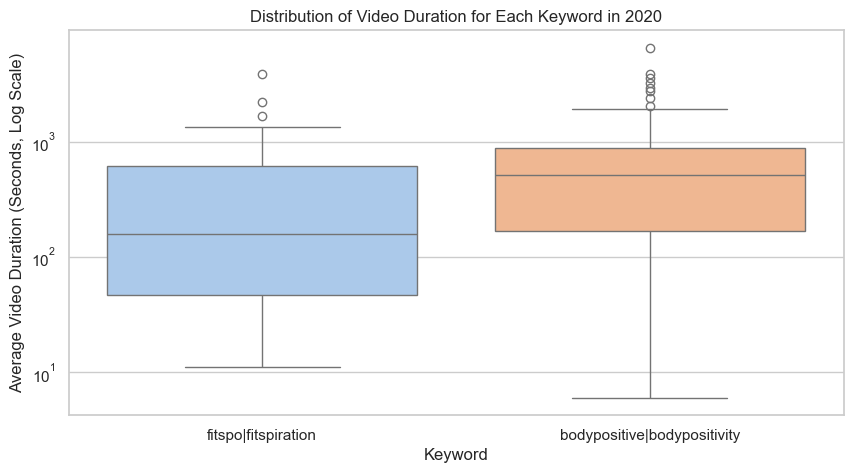

In [79]:
keyword_colors = [keyword_color_mapping[keyword] for keyword in df_video_year['keyword'].unique()]
sns.set(style="whitegrid")
fig, ax = plt.subplots(figsize=(10, 5))
sns.boxplot(data=df_video_year, x='keyword', y='duration', ax=ax, palette=keyword_colors)
ax.set_yscale('log')
ax.set_title(f'Distribution of Video Duration for Each Keyword in {year}')
ax.set_xlabel('Keyword')
ax.set_ylabel('Average Video Duration (Seconds, Log Scale)')

plt.savefig(f'results/boxplot_video_duration_{year}.png')
plt.show();

### Category ID of each keyword

In [83]:
df_category = get_category_mapping()
df_category.head()

,id,title
0,1,Film & Animation
1,2,Autos & Vehicles
2,10,Music
3,15,Pets & Animals
4,17,Sports


In [84]:
# map category_id to category_name
df_video['category_name'] = df_video['category_id'].apply(lambda x: df_category[df_category['id'] == int(x)]['title'].values[0])
df_video.head()

,video_id,published_at,channel_id,thumbnail_url,keyword,published_after,published_before,description,tags,category_id,title,channel_title,view_count,like_count,comment_count,duration,definition,publish_year,category_name
0,nhRzkGpdQdk,2013-03-12T17:09:50Z,UC3uDucFPe-E0I6CfxtHWZ6w,https://i.ytimg.com/vi/nhRzkGpdQdk/hqdefault.jpg,fitspo|fitspiration,2013-01-01T00:00:00Z,2013-06-30T23:59:59Z,Follow me on Facebook:\nhttp://www.facebook.co...,"[Bodybuilding Motivation, ShaQx, Female Fitnes...",17,Female Fitness Motivation - Success is a Journey,ShaQx,9762915.0,41921.0,1920.0,192,hd,2013,Sports
1,sIu61gS8Qag,2013-02-15T22:11:00Z,UC87WGiHFdgzRf6XRpbIcg4Q,https://i.ytimg.com/vi/sIu61gS8Qag/hqdefault.jpg,fitspo|fitspiration,2013-01-01T00:00:00Z,2013-06-30T23:59:59Z,This is a video I made for me to stay motivate...,"[fit, fitblr, fitspiration video, abs, motivat...",22,Fitspiration Video,Samora Lewis,211373.0,935.0,50.0,250,hd,2013,People & Blogs
2,Y4UyIC36VqQ,2013-02-11T03:44:28Z,UC9aRTMF4m6aBzkyhchwsWHQ,https://i.ytimg.com/vi/Y4UyIC36VqQ/hqdefault.jpg,fitspo|fitspiration,2013-01-01T00:00:00Z,2013-06-30T23:59:59Z,Find us at http://alluring-beauties.tumblr.com...,"[girls, weightloss, fitspo, thinsp, skinny, sl...",22,"Real Girl Weight loss, Before and After. Fitspo",AlluringBeautiesPage,108440.0,263.0,35.0,113,hd,2013,People & Blogs
3,HQtyF3YmYpw,2013-05-07T03:33:06Z,UCLIeO7AnzCpod8GiZsxyx5w,https://i.ytimg.com/vi/HQtyF3YmYpw/hqdefault.jpg,fitspo|fitspiration,2013-01-01T00:00:00Z,2013-06-30T23:59:59Z,just some weight lose/toning inspiration for y...,"[thinspo, curves, curvy, sexy, curvespo, lose ...",26,Fitspo for girls with curves 2013 (curvespo),LovesIt50,63819.0,83.0,3.0,253,sd,2013,Howto & Style
4,XXrvhTVlm0s,2013-03-16T18:17:29Z,UCgsNAoSMqikDqYOUXyasaLg,https://i.ytimg.com/vi/XXrvhTVlm0s/hqdefault.jpg,fitspo|fitspiration,2013-01-01T00:00:00Z,2013-06-30T23:59:59Z,hope you like this Fitspo Video :D \nwant to l...,"[fitspiration, fitspo, fitness, thin, thinspir...",22,FITSPIRATION - Fitnessmodel,fitandthin,30885.0,130.0,6.0,129,sd,2013,People & Blogs


In [85]:
df_video.to_parquet('preprocessed_data/video_info_details_raw.parquet') # save the data

In [117]:
df_category_percent = df_video.groupby(['keyword', 'category_name']).size().reset_index(name='count')
df_category_percent['total_count'] = df_category_percent.groupby('keyword')['count'].transform('sum')
df_category_percent['percentage'] = df_category_percent['count'] / df_category_percent['total_count'] * 100
df_category_percent.sort_values(by=['keyword', 'percentage'], ascending=[True, False], inplace=True)
df_category_percent.to_csv('results/category_percent_per_keyword.csv')
df_category_percent

,keyword,category_name,count,total_count,percentage
9,bodypositive|bodypositivity,People & Blogs,410,752,54.521277
5,bodypositive|bodypositivity,Howto & Style,110,752,14.627660
2,bodypositive|bodypositivity,Entertainment,99,752,13.164894
6,bodypositive|bodypositivity,Music,33,752,4.388298
8,bodypositive|bodypositivity,Nonprofits & Activism,20,752,2.659574
3,bodypositive|bodypositivity,Film & Animation,18,752,2.393617
1,bodypositive|bodypositivity,Education,15,752,1.994681
10,bodypositive|bodypositivity,Sports,15,752,1.994681
4,bodypositive|bodypositivity,Gaming,12,752,1.595745
0,bodypositive|bodypositivity,Comedy,10,752,1.329787


In [118]:
category_count = df_category_percent.groupby(['category_name'])[['count']].sum().sort_values(by='count', ascending=False)
category_count.to_csv('results/category_count.csv')
category_count

,count
category_name,
People & Blogs,898
Sports,265
Entertainment,204
Howto & Style,192
Music,56
Film & Animation,41
Education,34
News & Politics,34
Nonprofits & Activism,23


In [119]:
len(category_count)

15

In [106]:
# top 8 categories
category_count.index[:8]

Index(['People & Blogs', 'Sports', 'Entertainment', 'Howto & Style', 'Music',
       'Film & Animation', 'Education', 'News & Politics'],
      dtype='object', name='category_name')

In [126]:
# Define the order of categories
category_order = category_count.index[:8]

df_category_percent['category_name'] = pd.Categorical(df_category_percent['category_name'], categories=category_order, ordered=True)
df_category_percent.sort_values(by='category_name', inplace=True)
df_category_percent.reset_index(drop=True, inplace=True)
df_category_percent.dropna(axis=0, inplace=True)
df_category_percent

,keyword,category_name,count,total_count,percentage
0,bodypositive|bodypositivity,People & Blogs,410,752,54.521277
1,fitspo|fitspiration,People & Blogs,488,1045,46.698565
2,bodypositive|bodypositivity,Sports,15,752,1.994681
3,fitspo|fitspiration,Sports,250,1045,23.923445
4,bodypositive|bodypositivity,Entertainment,99,752,13.164894
5,fitspo|fitspiration,Entertainment,105,1045,10.047847
6,fitspo|fitspiration,Howto & Style,82,1045,7.846890
7,bodypositive|bodypositivity,Howto & Style,110,752,14.627660
8,fitspo|fitspiration,Music,23,1045,2.200957
9,bodypositive|bodypositivity,Music,33,752,4.388298


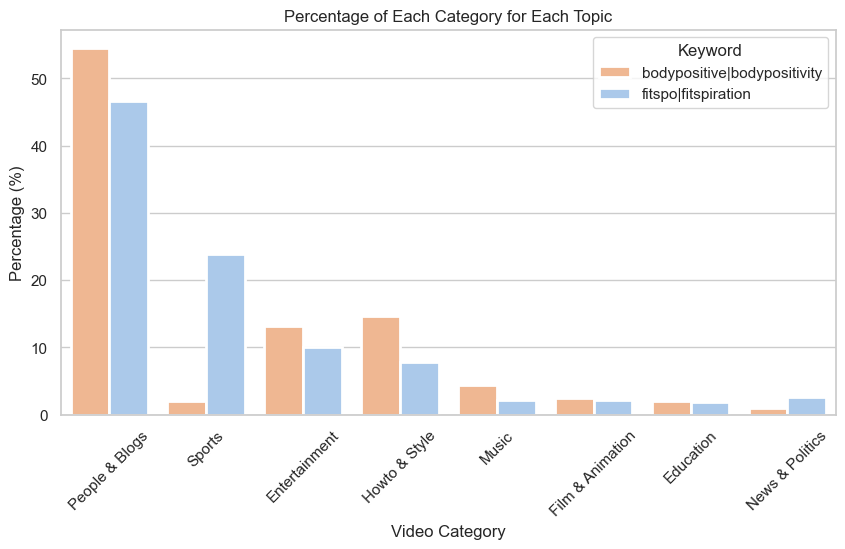

In [128]:
# histogram of the number of videos in each category for each keyword
keyword_colors = [keyword_color_mapping[keyword] for keyword in df_category_percent['keyword'].unique()]
sns.set(style="whitegrid")
fig, ax = plt.subplots(figsize=(10, 5))
sns.barplot(x='category_name', y='percentage', hue='keyword', data=df_category_percent, ax=ax, palette=keyword_colors, linewidth=2)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
ax.legend(title='Keyword', loc='upper right')
ax.set_title('Percentage of Each Category for Each Topic')
ax.set_xlabel('Video Category')
ax.set_ylabel('Percentage (%)')
plt.savefig('results/category_percent_per_keyword.png')

## Detect language of each video

In [ ]:
df_video = LanguageDetector().process_df(df_video)

In [ ]:
# top 5 languages
df_video['lang'].value_counts()[:5]

lang
en    1210
es     130
it      63
hi      63
sw      41
Name: count, dtype: int64

In [131]:
pd.read_parquet('preprocessed_data/video_info_details.parquet').shape

(1797, 21)

In [ ]:
# percentage of videos in English
df_video[df_video['lang'] == 'en'].shape[0]/len(df_video)

0.6733444629938787

In [ ]:
df_video[df_video['lang'] == 'en'].groupby('keyword').size().sort_values(ascending=False)

keyword
fitspo|fitspiration            793
bodypositive|bodypositivity    417
dtype: int64

In [ ]:
df_video.to_parquet('preprocessed_data/video_info_details.parquet') # save the data